In [2]:
!python --version

Python 3.11.11


#**CUDA**

In [3]:
import torch
cuda_available = torch.cuda.is_available()
if cuda_available:
    print(f"CUDA está disponible. Número de dispositivos: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"Dispositivo {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA no está disponible.")

CUDA está disponible. Número de dispositivos: 1
Dispositivo 0: Tesla T4


#**Descargar Librerías Necesarias**

In [4]:
import numpy as np
import pandas as pd
import json
import os

In [5]:
# Montar drive para obtener archivos necesarios
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
synthetic_ds_path = '/content/drive/MyDrive/Master/PRACTICAS/Datasets/synthetic_deepseek.csv'
print(os.path.exists(synthetic_ds_path))

synthetic_gpt_path = '/content/drive/MyDrive/Master/PRACTICAS/Datasets/synthetic_chatgpt.csv'
print(os.path.exists(synthetic_gpt_path))

synthetic_balancer_path ="/content/drive/MyDrive/Master/PRACTICAS/Datasets/synthetic_balancer.csv"
print(os.path.exists(synthetic_balancer_path))

synthetic_rd_path ="/content/drive/MyDrive/Master/PRACTICAS/Datasets/aug_x3_1400_with_RD.csv"
print(os.path.exists(synthetic_rd_path))
synthetic_rs_path ="/content/drive/MyDrive/Master/PRACTICAS/Datasets/aug_x3_1400_with_RS.csv"
print(os.path.exists(synthetic_rs_path))
synthetic_ri_path ="/content/drive/MyDrive/Master/PRACTICAS/Datasets/aug_x3_1400_with_RI.csv"
print(os.path.exists(synthetic_ri_path))
synthetic_sr_path ="/content/drive/MyDrive/Master/PRACTICAS/Datasets/aug_x3_1400_with_SR.csv"
print(os.path.exists(synthetic_sr_path))

dataset_path = '/content/drive/MyDrive/Master/PRACTICAS/Datasets/Dataset_Smishing14_1400.xlsx'
print(os.path.exists(dataset_path))

output_path = '/content/drive/MyDrive/Master/PRACTICAS/results'
print(os.path.exists(output_path))

logs_path = '/content/drive/MyDrive/Master/PRACTICAS/logs'
print(os.path.exists(logs_path))

models_path = '/content/drive/MyDrive/Master/PRACTICAS/models'
print(os.path.exists(logs_path))

True
True
True
True
True
True
True
True
True
True
True


In [7]:
!pip install simpletransformers
!pip install sacremoses
!pip install wget
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.3/316.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.9 MB/s eta 0:00:00
  C

In [8]:
# Librería auxiliar con metodos para preprocesamiento de datasets
import wget
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")

'helper_prabowo_ml.py'

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

from simpletransformers.classification import ClassificationModel, ClassificationArgs
import sacremoses
from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from datetime import datetime
import optuna

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#**Variables Globales**

In [10]:
MODELS = {
    "BERT": ["bert", "bert-base-uncased"],
    "ROBERTA": ["roberta", "roberta-base"],
    "DISTILBERT": ["distilbert", "distilbert-base-uncased"],
    "ALBERT": ["albert", "albert-base-v2"],
    "XLM_ROBERT": ["xlmroberta", "xlm-roberta-base"],
    "XLNET": ["xlnet", "xlnet-base-cased"]
}

#**Cargar Datasets**

In [11]:
def load_dataset(path):
  print("\n\n--------- DATASET ---------")
  try:
    df = pd.read_csv(path)
  except ValueError as ex:
    df = pd.read_excel(path)

  print("1. Forma original del dataset:")
  print(df.shape)
  print("2. Aquí están algunos ejemplos de este dataset:")
  print(df.head())
  print("3. Mensajes por categoría:")
  print(df['LABEL'].value_counts())
  print("4. Categorías diferentes:")
  print(df['LABEL'].unique())
  print("5. Voy a acomodar la estructura del dataset a mis necesidades:")
  ds = df[['TEXT', 'LABEL']]
  ds = ds.rename(columns={'LABEL': 'label', 'TEXT': 'sms'})
  print(ds.head())
  print("6. Voy a eliminar los NaN:")
  ds.dropna(inplace=True)
  print(f"---> Nuevo tamaño del dataset: {ds.shape}")
  print("7. Voy a eliminar los duplicados:")
  ds.drop_duplicates(inplace=True)
  print(f"---> Nuevo tamaño del dataset: {ds.shape}")
  return ds

In [12]:
df_real = load_dataset(dataset_path)
df_synth_gpt = load_dataset(synthetic_gpt_path)
df_synth_ds = load_dataset(synthetic_ds_path)
df_synth_bal = load_dataset(synthetic_balancer_path)

df_synth_rd = load_dataset(synthetic_rd_path)
df_synth_rs = load_dataset(synthetic_rs_path)
df_synth_ri = load_dataset(synthetic_ri_path)
df_synth_sr = load_dataset(synthetic_sr_path)



--------- DATASET ---------
1. Forma original del dataset:
(1434, 2)
2. Aquí están algunos ejemplos de este dataset:
                                                TEXT     LABEL
0  ! Warning:For security reasons your account wi...      Bank
1  ! BBVA Bank: From 03/04/2022 you will not be a...      Bank
2  +1 954-283-7757 BBVA: Dear customer, your acco...      Bank
3  +1 954-283-7757 BBVA: Dear customer, your acco...      Bank
4  11 Your account has been temporarily blocked f...  Accounts
3. Mensajes por categoría:
LABEL
Bank                370
Prizes              319
Offers              133
SMS_Service         106
Accounts             99
Deliveries           87
Dating               76
Spam                 69
Sexual               58
Gifts                50
Customer service     34
Finances             21
Sport news            6
Other                 5
Name: count, dtype: int64
4. Categorías diferentes:
['Bank' 'Accounts' 'Finances' 'Prizes' 'SMS_Service' 'Customer service'
 'Gifts' '

In [22]:
pd.concat([df_synth_rd, df_synth_ri, df_synth_rs, df_synth_sr])['label'].value_counts().sum()

16835

##**Gráficos de los datasets**

In [13]:
def plot_wordcloud(df):
  wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(df.sms))
  plt.imshow(wc);

In [14]:
def plot_num_words(df):
  num_words = df.sms.apply(len)
  sns.distplot(num_words)

In [15]:
def plot_lenght_distrib(df):
  num_words = df.sms.apply(len)
  sns.histplot(num_words, bins=30, kde=True, color='blue')
  plt.title("Distribución de longitudes de textos tokenizados")
  plt.xlabel("Longitud (tokens)")
  plt.ylabel("Frecuencia")
  plt.show()

In [16]:
def plot_percentile(df):
  num_words = df.sms.apply(len)
  p50 = np.percentile(num_words, 50)  # Mediana
  p90 = np.percentile(num_words, 90)  # Percentil 90
  p95 = np.percentile(num_words, 95)  # Percentil 95

  print(f"Percentil 50 (mediana): {p50}")
  print(f"Percentil 90: {p90}")
  print(f"Percentil 95: {p95}")

  sns.histplot(num_words, bins=30, kde=True, color='blue')
  plt.axvline(p50, color='green', linestyle='--', label=f"P50: {p50}")
  plt.axvline(p90, color='orange', linestyle='--', label=f"P90: {p90}")
  plt.axvline(p95, color='red', linestyle='--', label=f"P95: {p95}")

  plt.title("Distribución de longitudes con percentiles")
  plt.xlabel("Longitud (tokens)")
  plt.ylabel("Frecuencia")
  plt.legend()
  plt.show()


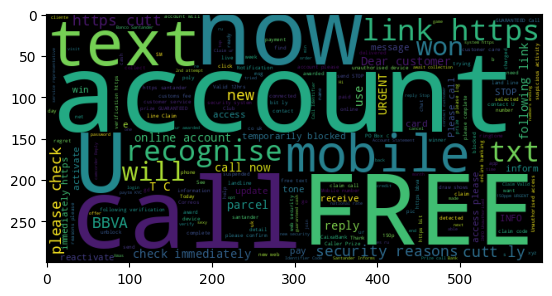

In [17]:
plot_wordcloud(df_real)

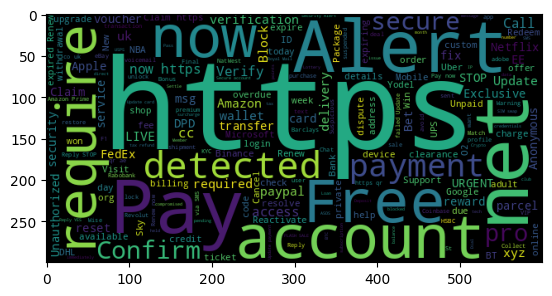

In [18]:
plot_wordcloud(df_synth_ds)

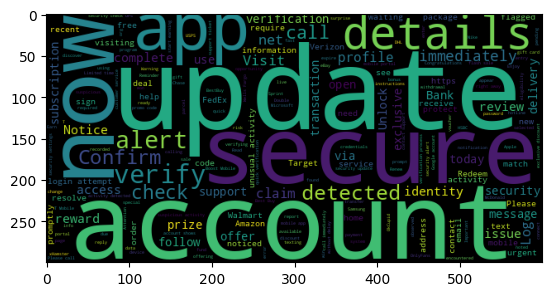

In [19]:
plot_wordcloud(df_synth_gpt)

Percentil 50 (mediana): 147.0
Percentil 90: 167.9000000000001
Percentil 95: 182.0


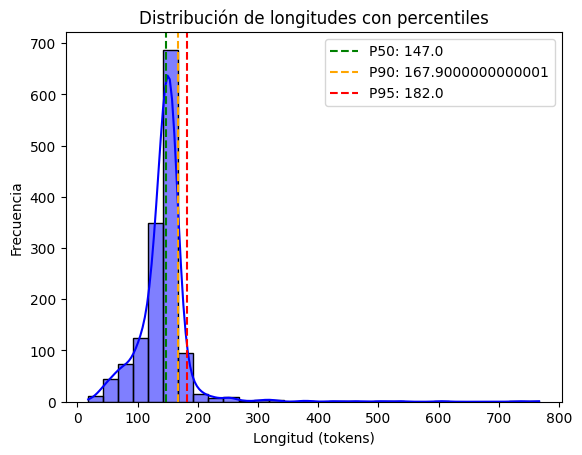

Percentil 50 (mediana): 83.0
Percentil 90: 104.0
Percentil 95: 111.0


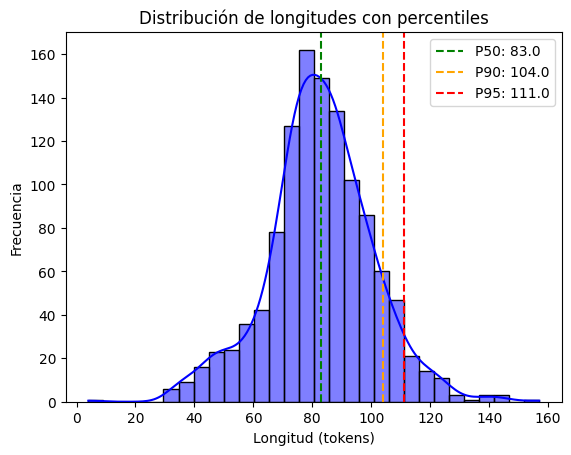

Percentil 50 (mediana): 115.0
Percentil 90: 140.0
Percentil 95: 151.0


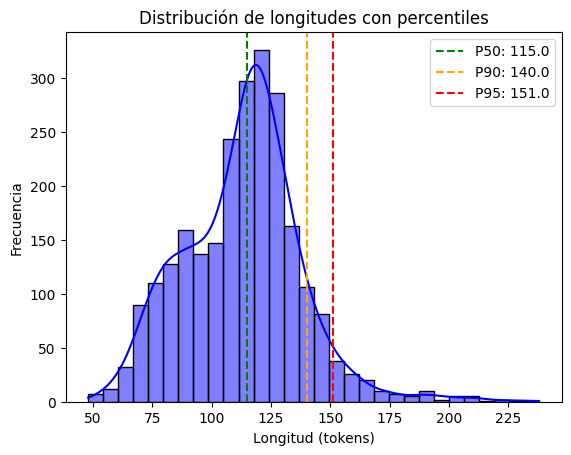

Percentil 50 (mediana): 131.0
Percentil 90: 155.0
Percentil 95: 163.0


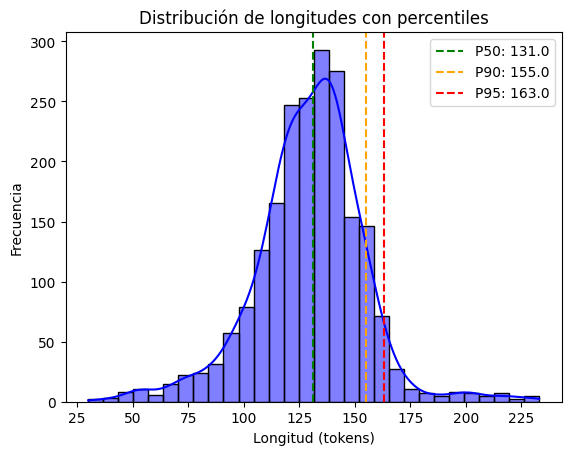

In [20]:
plot_percentile(df_real)
plot_percentile(df_synth_ds)
plot_percentile(df_synth_gpt)
plot_percentile(df_synth_bal)

##**Preprocesamiento de los Datasets**

In [21]:
import re
# remove email address
def token_email_address(text):
  email = re.compile(r'[\w\.-]+@[\w\.-]+')
  return email.sub(r'[email]',text)

In [22]:
def token_links(text):
  text = re.sub(r'http\S+', '[link]', text) # detect http y https links
  text = re.sub(r'bit\.ly/\S+', '[link]', text) # detect bitly links
  text = re.sub(r'goo\.gl/\S+', '[link]', text)
  text = re.sub(r'tinyurl\.com/\S+', '[link]', text)
  text = re.sub(r'is\.gd/\S+', '[link]', text)
  text = re.sub(r'ow\.ly/\S+', '[link]', text)
  text = re.sub(r'buff\.ly/\S+', '[link]', text)
  text = re.sub(r'adf\.ly/\S+', '[link]', text)
  text = re.sub(r'bit\.do/\S+', '[link]', text)
  text = re.sub(r't\.co/\S+', '[link]', text)
  text = re.sub(r'shrtco\.de/\S+', '[link]', text)
  text = re.sub(r'cutt\.ly/\S+', '[link]', text)
  text = re.sub(r'v\.gd/\S+', '[link]', text)
  text = re.sub(r'lnkd\.in/\S+', '[link]', text)
  text = re.sub(r'rebrand\.ly/\S+', '[link]', text)
  text = re.sub(r'clck\.ru/\S+', '[link]', text)
  text = re.sub(r'www\.\S+', '[link]', text) # detect www links
  return text

In [23]:
def token_digits(text):
  text = re.sub(r'\d+((\.|,)\d+)?', '[num]', text)
  return text

In [24]:
def text_preprocess(data,col):
  data[col] = data[col].apply(func=clean_html)
  data[col] = data[col].apply(func=remove_)

  #Tokenizar
  data[col] = data[col].apply(func=token_email_address)
  data[col] = data[col].apply(func=token_links)
  data[col] = data[col].apply(func=token_digits)
  data[col] = data[col].apply(func=remove_special_characters)

  data[col] = data[col].apply(func=non_ascii)
  data[col] = data[col].apply(func=lower)
  return data

In [25]:
# Qutar categoria Other (ESTO NO HACE FALTA PARA LOS DATASETS MIMICS)
df_synth_bal = df_synth_bal[df_synth_bal['label']!='Other']
df_synth_gpt = df_synth_gpt[df_synth_gpt['label']!='Other']
df_synth_ds = df_synth_ds[df_synth_ds['label']!='Other']
df_real = df_real[df_real['label']!='Other']

df_synth_rd = df_synth_rd[df_synth_rd['label']!='Other']
df_synth_rs = df_synth_rs[df_synth_rs['label']!='Other']
df_synth_ri = df_synth_ri[df_synth_ri['label']!='Other']
df_synth_sr = df_synth_sr[df_synth_sr['label']!='Other']

In [26]:
df_synth_bal = text_preprocess(df_synth_bal,'sms')
df_synth_gpt = text_preprocess(df_synth_gpt,'sms')
df_synth_ds = text_preprocess(df_synth_ds,'sms')
df_real = text_preprocess(df_real,'sms')

df_synth_rd = text_preprocess(df_synth_rd,'sms')
df_synth_rs = text_preprocess(df_synth_rs,'sms')
df_synth_ri = text_preprocess(df_synth_ri,'sms')
df_synth_sr = text_preprocess(df_synth_sr,'sms')

In [27]:
print(f"df_synth_bal -> {df_synth_bal.shape}")
print(f"df_synth_gpt -> {df_synth_gpt.shape}")
print(f"df_synth_ds -> {df_synth_ds.shape}")
print(f"df_real -> {df_real.shape}")

print(f"df_RD -> {df_synth_rd.shape}")
print(f"df_RS -> {df_synth_rs.shape}")
print(f"df_RI -> {df_synth_ri.shape}")
print(f"df_SR -> {df_synth_sr.shape}")

df_synth_bal -> (2072, 2)
df_synth_gpt -> (2260, 2)
df_synth_ds -> (1154, 2)
df_real -> (1427, 2)
df_RD -> (4064, 2)
df_RS -> (4248, 2)
df_RI -> (4276, 2)
df_SR -> (4188, 2)


##**División y unión de los datasets**

In [28]:
def augmentation(df_real, augment, *args):
  #Juntar y preparar los DF
  df_pool = pd.DataFrame()
  for df in args:
    df_pool = pd.concat([df_pool, df], ignore_index=True)
  df_pool = df_pool.sample(frac=1, random_state=42).reset_index(drop=True)

  print(df_pool.shape)

  # Get number of needed samples
  msgs, _ = df_real.shape
  msgs_req = round(msgs * augment)

  # Get subpool
  msgs_available, _ = df_pool.shape
  if msgs_available >= msgs_req:
    df_subpool = df_pool.sample(n=msgs_req, random_state=42)
  else:
    print("No hay suficientes mensajes para ese tamaño. Vamos a usar todo el dataset.")
    df_subpool = df_pool.sample(n=msgs_available, random_state=42)

  return pd.concat([df_real, df_subpool], ignore_index=True)

In [29]:
AUGMENT = 12

total_data = augmentation(df_real, AUGMENT, df_synth_bal, df_synth_rd, df_synth_rs, df_synth_ri, df_synth_sr)
train_data, test_data = train_test_split(total_data, test_size=0.3, random_state=42, shuffle=True)

label_list = train_data['label'].unique().tolist()
aug = f"x{AUGMENT+1}".replace('.', '')

(18848, 2)


In [30]:
print(f"Antes: {df_real.shape[0]} muestras")
print(f"Ahora: {total_data.shape[0]} muestras")

Antes: 1427 muestras
Ahora: 18551 muestras


## **Información nuevo dataset**

Percentil 50 (mediana): 139.0
Percentil 90: 175.0
Percentil 95: 188.0


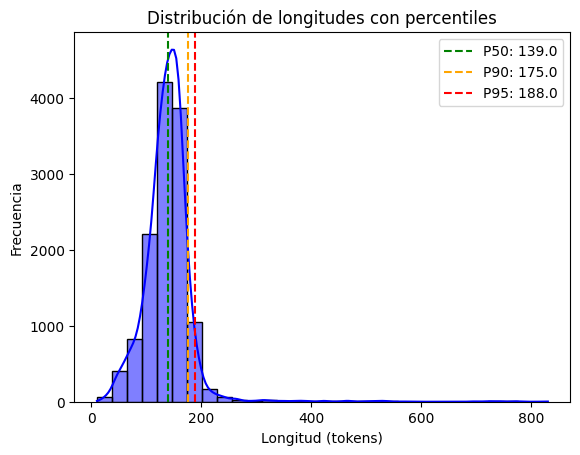

Percentil 50 (mediana): 141.0
Percentil 90: 175.0
Percentil 95: 190.0


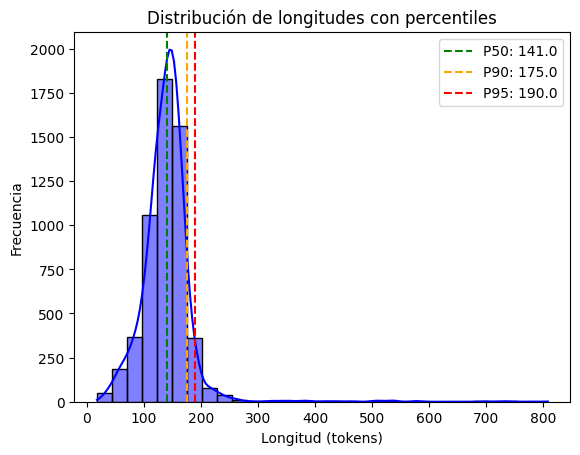

In [31]:
plot_percentile(train_data)
plot_percentile(test_data)

In [32]:
test_data['label'].value_counts()

,count
label,
Bank,1296
Prizes,1138
Offers,517
SMS_Service,396
Accounts,384
Deliveries,357
Dating,295
Spam,277
Sexual,255


In [33]:
train_data['label'].value_counts()

,count
label,
Bank,3006
Prizes,2621
Offers,1109
SMS_Service,985
Accounts,928
Deliveries,869
Dating,728
Spam,713
Sexual,570


#**Cuerpo de los modelos**

In [34]:
def save_model(name, model, timestamp, augment, label: str = ""):
  if label != "":
    name = f"{name}_{label}"
  model_path = f"{models_path}/{name}_{augment}_{timestamp}"

  # Asegúrate de que el directorio exista
  os.makedirs(os.path.dirname(model_path), exist_ok=True)

  print(f"Guardando en: {model_path}")
  model.model.save_pretrained(model_path)
  model.tokenizer.save_pretrained(model_path)

  # Guardar los argumentos
  args_path = f"{models_path}/{name}_{augment}_{timestamp}/training_args.json"
  with open(args_path, "w") as f:
    json.dump(vars(model.args), f, indent=4)

In [35]:
def save_results(name, results, timestamp, augment, label:str = ""):
  if label != "":
    name = f"{name}_{label}"
  path = f"{models_path}/{name}_{augment}_{timestamp}/eval_results.txt"

  # Asegúrate de que el directorio exista
  os.makedirs(os.path.dirname(path), exist_ok=True)

  # Guardar los resultados en el path
  with open(path, "w") as f:
    for metric, value in results.items():
        f.write(f"{metric}: {value}\n")

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score

def compute_metrics(preds, labels):
    """
    Calcula múltiples métricas a partir de las predicciones y las etiquetas reales.
    """
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    mcc = matthews_corrcoef(labels, preds)

    #Matriz de Confusión
    # conf_matrix = confusion_matrix(labels, preds)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mcc": mcc,
        # "confusion_matrix": conf_matrix
    }

In [37]:
def get_model_args(
    label_list: list[str], max_length, output, logs, lazy_loading: bool = False
    ):
  """
    Devuelve los argumentos que personalizan el modelo.
  """

  model_args = ClassificationArgs()

  # # Hiperparámetros de entrenamiento
  # model_args.learning_rate = 2e-5  # Tasa de aprendizaje pequeña, porque no tenemos muchos datos
  # model_args.train_batch_size = 8  # Tamaño del batch pequeño para evitar sobreajuste
  # model_args.eval_batch_size = 8  # Evaluación con batch pequeño también
  # model_args.num_train_epochs = 3  # Número de épocas. Usamos pocas épocas para evitar sobreajuste
  # model_args.max_seq_length = max_length
  # model_args.warmup_steps = 100  # Pasos de warmup para evitar altas tasas de aprendizaje al principio
  # model_args.weight_decay = 0.01  # Regularización L2 (weight decay) para evitar sobreajuste
  # model_args.dropout = 0.1  # Tasa de dropout para evitar sobreajuste
  # model_args.no_save = False  # Guardar el modelo al final del entrenamiento

  # Hiperparámetros de entrenamiento
  model_args.learning_rate = 1.9669309063203514e-05  # Tasa de aprendizaje pequeña, porque no tenemos muchos datos
  model_args.train_batch_size = 64  # Tamaño del batch pequeño para evitar sobreajuste
  model_args.eval_batch_size = 64  # Evaluación con batch pequeño también
  model_args.num_train_epochs = 8  # Número de épocas. Usamos pocas épocas para evitar sobreajuste
  model_args.max_seq_length = 147
  model_args.warmup_steps = 31  # Pasos de warmup para evitar altas tasas de aprendizaje al principio
  model_args.weight_decay = 0.0  # Regularización L2 (weight decay) para evitar sobreajuste
  model_args.dropout = 0.2  # Tasa de dropout para evitar sobreajuste
  model_args.no_save = False  # Guardar el modelo al final del entrenamiento

  # Early stopping (Da problemas)
  model_args.use_early_stopping = True  # Usar detención temprana para evitar sobreajuste
  model_args.early_stopping_metric = "mcc"
  model_args.early_stopping_metric_minimize = False
  model_args.early_stopping_patience = 2  # Paciencia para la detención temprana (por ejemplo, 2 épocas sin mejora)

  # Otros parámetros
  model_args.labels_list = label_list
  model_args.output_dir = output
  model_args.overwrite_output_dir = True

  return model_args


In [38]:
def get_model(model_choice: str, model_args, label_list, use_cuda: bool = False):
  """
    Devuelve un modelo de HuggingFace a través de la librería de SimpleTransformers.
  """
  model_type, model_name = MODELS[model_choice]
  model = ClassificationModel(
      model_type,
      model_name,
      use_cuda = use_cuda,   # Si hacemos uso de una GPU compatible con CUDA quitar esto o poner True
      num_labels = len(label_list),
      args=model_args
      )
  print(model.model)
  return model


In [39]:
def test_model(m, train_data, test_data, label_list, max_length, use_cuda, augment):
  """
  Ejecuta un modelo de los disponibles en la lista y guarda el modelo, su resultado y sus outputs.
  Esta función implica hacer fine-tunning del modelo
  """
  # Generar el timestamp
  timestamp = datetime.now().strftime("%d%m%y_%H%M%S")

  # Ejecución de prueba para un modelo con los argumentos default
  output = f"/content/drive/MyDrive/Master/PRACTICAS/outputs/{m}"
  logs = f"/content/drive/MyDrive/Master/PRACTICAS/logs/{m}"
  model_args = get_model_args(label_list=label_list, max_length=max_length, output=output, logs=logs)
  model = get_model(m, model_args, label_list=label_list, use_cuda=use_cuda)

  # Entrenamiento del modelo
  model.train_model(train_data, eval_df=test_data, compute_metrics=compute_metrics)
  save_model(m, model, timestamp, augment)

  # Evaluar el modelo
  result, model_outputs, wrong_predictions = model.eval_model(test_data, compute_metrics=compute_metrics)
  save_results(m, result, timestamp, augment)

In [40]:
def test_all_models(train_data, test_data, label_list, max_length, use_cuda, augment, finetune=True):
  """
  Ejecuta todos los modelos disponibles en la lista y guarda el modelo, su resultado y sus outputs.
  Se puede elegir si hacer fine tunning o no.
  """
  for m in MODELS:
    print(f"Vamos con el modelo {m} de longitud {max_length} y labels: {label_list}")
    if finetune:
      print("Fine tunning")
      test_model(m, train_data, test_data, label_list, max_length, use_cuda, augment)
    else:
      print("No fine tunnig: NO DISPONIBLE")
      # test_model_no_fine_tune(m, train_data, test_data, label_list, max_length)

# **Optimización de parámetros**

In [41]:
def get_optimized_model_args(label_list: list[str], trial):
  """
    Devuelve los argumentos del modelo que incormoran la notación de optuna para
    optimizar hyperparámetros.
  """

  model_args = ClassificationArgs()

    # Hiperparámetros actuales con ajustes y ampliaciones:
  model_args.learning_rate = trial.suggest_loguniform('learning_rate', 5e-6, 5e-5)
  model_args.train_batch_size = trial.suggest_categorical('train_batch_size', [16, 32, 64])
  model_args.eval_batch_size = 8
  model_args.num_train_epochs = trial.suggest_int('num_train_epochs', 4, 8)
  model_args.max_seq_length = trial.suggest_categorical('max_seq_length', [147, 168, 182, 196])
  model_args.warmup_steps = trial.suggest_categorical('warmup_steps', [0, 50, 100, 300])
  model_args.weight_decay = trial.suggest_categorical('weight_decay', [0.01, 0.05, 0.1])
  model_args.dropout = trial.suggest_categorical('dropout', [0.1, 0.2, 0.3, 0.4])
  model_args.gradient_accumulation_steps = trial.suggest_categorical('gradient_accumulation_steps', [1, 2, 4])
  model_args.adam_epsilon = trial.suggest_loguniform('adam_epsilon', 1e-8, 1e-6)  # Ajuste fino del optimizador Adam para estabilidad numérica.

  # model_args.scheduler = trial.suggest_categorical('scheduler', ['linear_with_warmup', 'cosine_with_warmup', 'cosine_with_hard_restarts_with_warmup'])  # Experimentación con diferentes planificadores de tasas de aprendizaje para manejar la convergencia.
  model_args.fp16 = trial.suggest_categorical('fp16', [True, False])  # Evaluación de entrenamiento en precisión mixta (Half Precision), útil para acelerar el entrenamiento.
  model_args.max_grad_norm = trial.suggest_categorical('max_grad_norm', [0.5, 1.0, 5.0, 10.0])
  model_args.save_steps = trial.suggest_int('save_steps', 100, 500)

  # Early stopping (se puede controlar también)
  model_args.use_early_stopping = True
  model_args.early_stopping_metric = "mcc"
  model_args.early_stopping_metric_minimize = False
  model_args.early_stopping_patience = 2

  # Otros parámetros
  model_args.labels_list = label_list
  model_args.reprocess_input_data = True
  model_args.evaluate_during_training = True
  model_args.use_multiprocessing = True
  model_args.overwrite_output_dir = True

  return model_args

In [42]:
class Optimizator:
    def __init__(self, m, train_data, test_data, label_list, use_cuda=True):
        self.m = m
        self.train_data = train_data
        self.test_data = test_data
        self.label_list = label_list
        self.use_cuda = use_cuda
        self.best_score = -float("inf")
        self.best_model = None
        self.best_results = None

    def __call__(self, trial):
        # Obtener modelo
        model_args = get_optimized_model_args(label_list=self.label_list, trial=trial)
        model = get_model(self.m, model_args, label_list=self.label_list, use_cuda=self.use_cuda)

        # Entrenar el modelo
        model.train_model(self.train_data, eval_df=self.test_data, compute_metrics=compute_metrics)

        # Evaluar el modelo
        result, _, _ = model.eval_model(self.test_data, compute_metrics=compute_metrics)

        # Optuna maximiza el valor de f1
        print(result)
        f1_score = result['compute_metrics']['f1']
        print(f"F1 Score: {f1_score}")

        # Comprobar modelo
        if f1_score > self.best_score:
            self.best_score = f1_score
            self.best_model = model
            self.best_results = result

        return f1_score

In [43]:
def optimize_model(m, train_data, test_data, label_list, use_cuda, augment):
  # Generar el timestamp
  timestamp = datetime.now().strftime("%d%m%y_%H%M%S")

  #
  optimizator = Optimizator(m, train_data, test_data, label_list, use_cuda=use_cuda)

  # Configuración de Optuna
  study = optuna.create_study(direction="maximize")  # Maximizar F1 Score
  study.optimize(optimizator, n_trials=10)  # Número de intentos de prueba

  # Ver los mejores hiperparámetros encontrados por Optuna
  print("Mejores parámetros:", study.best_params)

  # Guardar modelo y resultados
  save_model(m,  optimizator.best_model, timestamp, augment, "optimized")
  save_results(m, optimizator.best_results, timestamp, augment, "optimized")

In [44]:
def optimize_all_models(train_data, test_data, label_list, use_cuda, augment):
  """

  """
  for m in MODELS:
    print(f"=======> Vamos con el modelo {m} ")
    optimize_model(m, train_data, test_data, label_list, use_cuda, augment)

##**Ejecución de Modelos (No Opt)**

In [47]:
# --> Descarga, entrena, testea y guarda un modelo de la lista
# test_model("BERT", train_data, test_data, label_list, 168, cuda_available, aug)

# --> Descarga, entrena, testea y guarda todos los modelos de la lista
test_all_models(train_data, test_data, label_list, 168, cuda_available, aug)

Vamos con el modelo ROBERTA de longitud 168 y labels: ['Sexual', 'Prizes', 'Bank', 'Gifts', 'Finances', 'Offers', 'Deliveries', 'SMS_Service', 'Dating', 'Accounts', 'Spam', 'Sport news', 'Customer service']
Fine tunning


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 8 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Guardando en: /content/drive/MyDrive/Master/PRACTICAS/models/ROBERTA_x13_110325_085325


/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/11 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Vamos con el modelo DISTILBERT de longitud 168 y labels: ['Sexual', 'Prizes', 'Bank', 'Gifts', 'Finances', 'Offers', 'Deliveries', 'SMS_Service', 'Dating', 'Accounts', 'Spam', 'Sport news', 'Customer service']
Fine tunning


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 8 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Guardando en: /content/drive/MyDrive/Master/PRACTICAS/models/DISTILBERT_x13_110325_090623


/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/11 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Vamos con el modelo ALBERT de longitud 168 y labels: ['Sexual', 'Prizes', 'Bank', 'Gifts', 'Finances', 'Offers', 'Deliveries', 'SMS_Service', 'Dating', 'Accounts', 'Spam', 'Sport news', 'Customer service']
Fine tunning


config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 8 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Guardando en: /content/drive/MyDrive/Master/PRACTICAS/models/ALBERT_x13_110325_091256


/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/11 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Vamos con el modelo XLM_ROBERT de longitud 168 y labels: ['Sexual', 'Prizes', 'Bank', 'Gifts', 'Finances', 'Offers', 'Deliveries', 'SMS_Service', 'Dating', 'Accounts', 'Spam', 'Sport news', 'Customer service']
Fine tunning


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:484: UserWarning: use_multiprocessing automatically disabled as xlmroberta fails when using multiprocessing for feature conversion.
  warnings.warn(


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 8 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Guardando en: /content/drive/MyDrive/Master/PRACTICAS/models/XLM_ROBERT_x13_110325_092920


/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/11 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Vamos con el modelo XLNET de longitud 168 y labels: ['Sexual', 'Prizes', 'Bank', 'Gifts', 'Finances', 'Offers', 'Deliveries', 'SMS_Service', 'Dating', 'Accounts', 'Spam', 'Sport news', 'Customer service']
Fine tunning


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

model.safetensors:   0%|          | 0.00/467M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 3 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 4 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 5 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 6 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 7 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Running Epoch 8 of 8:   0%|          | 0/203 [00:00<?, ?it/s]

Guardando en: /content/drive/MyDrive/Master/PRACTICAS/models/XLNET_x13_110325_094708


/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/11 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/87 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


## **Ejecución de Optimización**

In [ ]:
# aug = f"x{AUGMENT+1}".replace('.', '')
# optimize_all_models(train_data, test_data, label_list, cuda_available, aug)


# optimize_model('DISTILBERT', train_data, test_data, label_list, cuda_available, aug)